# Вступление

Этот проект показывает: 
- способность писать структурированный код на Python. 
- возможность использования существующих утилит(библиотек) для обработки
- навыки предварительной обработки данных
- Предобработка текста:
    - лемматизация
    - работа с регулярными выражениями
    - преобразование текста tf-idf
- использование моделей Машинного Обучения

Проект включает в себя:
1. Работа с NLP:
    - Предобработка, преобразование текста для моделей Машинного обучения
2. Работа с моделями Машинного обучения:
    - Logistic Regression
    - Decision Tree
    - Random Forest
    - XGBoost
    - LightGBM

Проект из учебного курса "[Специалист по Data Science](https://praktikum.yandex.ru/data-scientist)" от [Яндекс Практикум](https://practicum.yandex.ru/).

# Подготовка проекта

In [2]:
%%html
<style>
table {float:left}
</style>

In [2]:
!pip install catboost

## Импорт библиотек

In [3]:
import numpy as np
import pandas as pd
from scipy import stats as st
import time
import warnings
import datetime
# Для чтения файла
import os 
from pathlib import Path
import urllib
# Подготовка текста
import re
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
# Модели машинного обучения для задач классификации
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
# Для разделения данных на обучающий, валидационный, тестовый набор данных. 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# Метрики классификации - оценка моделей
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
# Для upsampling или downsampling 
from sklearn.utils import shuffle
# Для проверки модели на вменяемость
from sklearn.dummy import DummyClassifier
# Для визуализации графиков
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Настройка matplotlib

In [4]:
%matplotlib inline
small, medium, large = 14, 16, 22
params = {'figure.figsize':   (14, 5),
          'figure.titlesize': medium,
          'legend.fontsize':  small,
          'axes.titlesize':   small,
          'axes.labelsize':   small,
          'xtick.labelsize':  small,
          'ytick.labelsize':  small,
          'legend.loc':       'best'}
plt.rcParams.update(params)

In [5]:
# повышение четкости на больших экранах
%config InlineBackend.figure_format = 'retina'

In [6]:
# отключим всякие предупреждения Anaconda
warnings.filterwarnings('ignore')

In [7]:
# уберём экспоненциальную запись
pd.options.display.float_format = '{:.3f}'.format

In [8]:
# вывод всех столбцов
pd.set_option('display.max_columns', None)

# Машинное обучение для текстов

# Проект "Определение токсичных комментариев"

## Описание проекта 

Интернет-магазин запускает новый сервис. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модернизацию.

## Описание данных

Предоставлены данные - комментарии с разметкой о токсичности правок.

## Детали задачи
Заказчику важны:
- Значение метрики F1 должно быть не меньше 75.





 |Столбец            |Описание          |Тип столбца
 |:---------------|:------------------------|:-------------|
 |text    | Текст комментария|features  |
 |toxic   | Индикатор токсичен ли комментарий | target |

## Цель проекта
Построить модель, которая будет классифицировать комментарии на позитивные и негативные.

## План работы
1. [Обзор данных](#review)
2. [Предобработка данных](#dataPreprocessing)
    - [Лемматизация](#lemmatization)
    - [Предобработка текста](#textProcessing)
    - [Разделение данных](#dataSeparation)
    - [Upsampling](#upsampling)
    - [Преобразование данных](#dataProcessing)
3. [Исследование моделей машинного обучения](#MLmodelResearch)
    - [Logistic Regression с перебором параметров с помощью GridSearch](#logisticRegression)
    - [Decision Tree с перебором параметров](#decisionTree)
    - [Random Forest с перебором параметров](#randomForest)
    - [XGBoost](#XGBoost)
    - [LightGBM](#lightgmb)
4. [Результаты исследования моделей машинного обучения](#resultsRearchModel)
5. [Результаты работы](#results)

<a id="review"></a>
# Этап 1 - Обзор данных

Прочитаем предоставленный файл. Сохраним в соотвествующую переменную.

In [9]:
Path('datasets').mkdir(parents=True, exist_ok=True)
#Создаем функцию для чтения файла
def get_file(file_name, url):
    # Проверяем есть ли файл
    if not os.path.exists(file_name):
        print(file_name,'файл не найден, будет загружен из сети')
        # качаем файл по ссылке url, кладем по пути file_name
        # загружаем с помощью библиотеки urllib
        _ = urllib.request.urlretrieve(url, file_name)
        
# Словарь с именем файла и ссылкой на него
urls = {
    'comments': ('datasets/toxic_comments.csv', '_____________'),
}
[get_file(*urls[k]) for k in urls]
[get_file(urls[k][0], urls[k][1]) for k in urls]

# сохраним полученный из файла датафрейм в соответствующую переменную
raw_comments = pd.read_csv(urls['comments'][0],sep=',')

Посмотрим на данные. Выведем первые 10 строк таблицы.

In [10]:
raw_comments.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


Заметим в тексте есть *\n* символ. Комментарии на английском языке.

Посмотрим на общие данные, вызвав метод *info()*

In [11]:
raw_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В выборке - 159571 обьектов. 2 столбца: *text* с типом данных *object* и toxic с типом данных *int64*. Пропущенных значений нету.

Посмотрим сколько обьектов в каждом классе *toxic*.

In [12]:
raw_comments['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [13]:
toxic = raw_comments[raw_comments['toxic']==1]
non_toxic = raw_comments[raw_comments['toxic']==0]

In [14]:
num_obj_in_class = pd.DataFrame(data={'class': ['toxic','non_toxic'], 'num_objects': [len(toxic), len(non_toxic)]})
num_obj_in_class

,class,num_objects
0,toxic,16225
1,non_toxic,143346


Создадим функцию для вывода графика

In [15]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title):
    """
    Функция отрисовки графика
    df - данные
    x_axis - ось x
    y_axis - ось y
    x_label - название оси x
    y_label - название оси y
    plot_title - заголовок
    order - столбец по которому будет определяться порядок
    """
    # Заголовок
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df)
    # подписать оси 
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

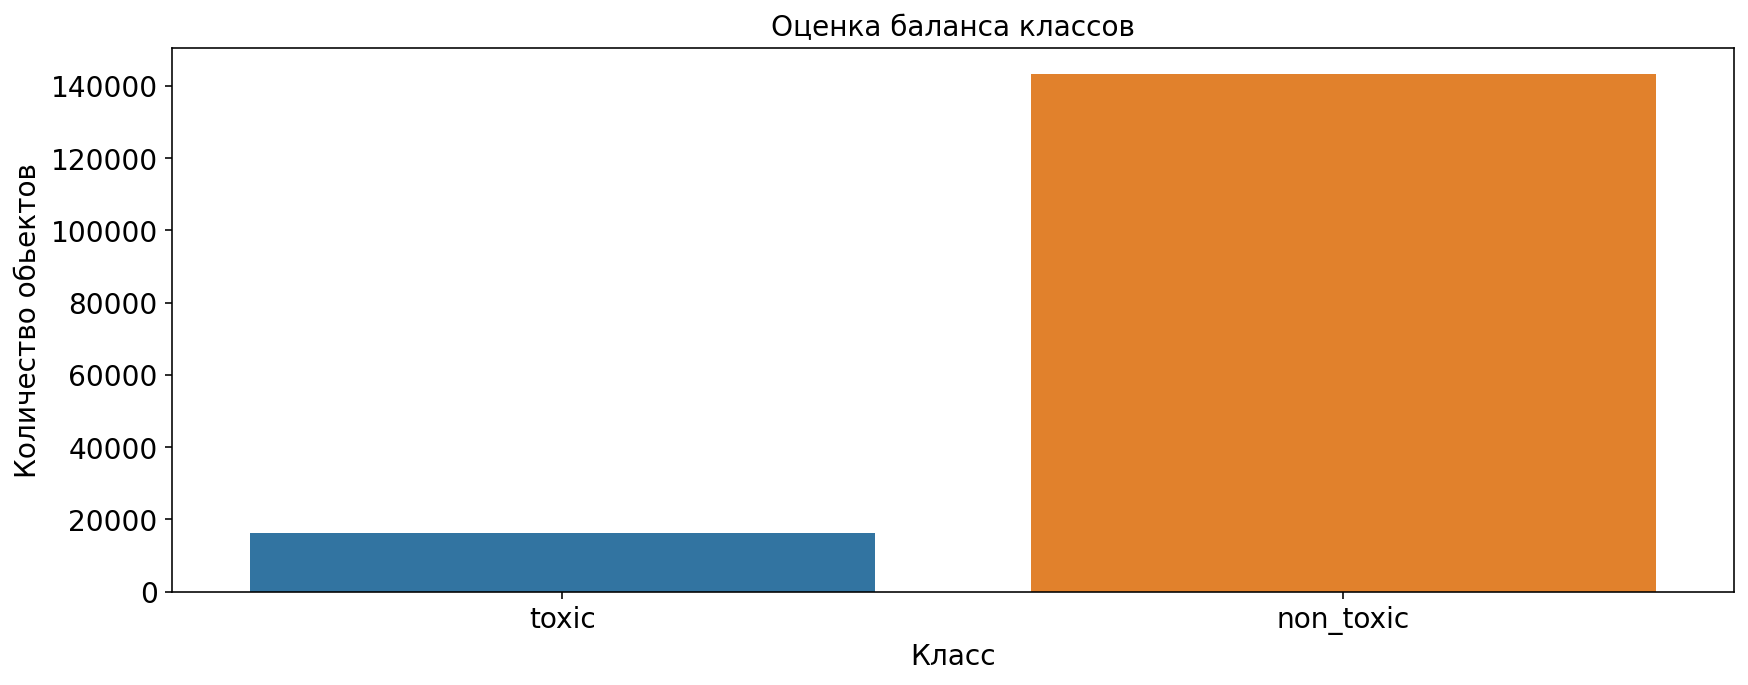

In [16]:
drawPlot(num_obj_in_class, 'class', 'num_objects', "Класс", "Количество обьектов", "Оценка баланса классов")

Как видим, количество не токсичных комментариев гораздо больше. Следовательно, у нас не сбалансированные данные.

## Вывод

В выборке - 159571 обьектов. 2 столбца: text с типом данных object и toxic с типом данных int64. Пропущенных значений нету. Комментарии на английском языке.  Количество не токсичных комментариев гораздо больше. У нас не сбалансированные данные. Нам необходимо:
1. Предобработать данные:
    - лемматизировать текст
2. Исследовать модели машинного обучения
    - выбрать модель с самым лучшим показателем на метрике F1

<br>

<a id="dataPreprocessing"></a>
# Этап 2 - Предобработка данных

На этом этапе нам необходимо предобработать текст. Выполнить лемматизацию. Убрать спецсимволы.

Создадим корпус.

In [17]:
corpus = raw_comments['text'].values

<a id="regExpProcessing"><a>
## Предобработка текста регулярными выражениями.

Предобработаем каждый коммент регуларными выражениями: удалим спецсимволы, цифры, и пробелы.

In [18]:
def clear_text(text):
    """
    Функция очищает текст от спецсимволов, цифр и пробелов
    text - текст который нужно очистить
    """
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

Проверим

In [19]:
corpus[1]

"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [20]:
clear_text(corpus[1])

'D aww He matches this background colour I m seemingly stuck with Thanks talk January UTC'

<a id="lemmatization"></a>
## Лемматизация

Лемматизируем каждый комментарий. 

In [21]:
lemmatizer = WordNetLemmatizer()

In [22]:
def lemmatize(text):
    """
    Функция лемматизирует текст
    text - текст который нужно лемматизировать
    """
    # токенизируем текст
    word_list = nltk.word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in word_list]
    return " ".join(lemmatized)

Проверка

In [23]:
corpus[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [24]:
lemmatize(clear_text(corpus[0]))

'Explanation Why the edits made under my username Hardcore Metallica Fan were reverted They weren t vandalism just closure on some GAs after I voted at New York Dolls FAC And please don t remove the template from the talk page since I m retired now'

<a id="textProcessing"></a>
## Предобработка текста

Выполним предобработку каждого комментария.

In [25]:
processed_corpus = []

In [26]:
for comment in corpus: 
    processed_corpus.append(lemmatize(clear_text(comment)))

In [27]:
cleared = pd.Series(processed_corpus)

Предобработали текст, теперь разделим его.

<a id="dataSeparation"></a>
## Разделение данных

Мы разделим выборку для кросс-валидации. Разделим исходные данные на 2 выборки: обучающую и тестовую в соотношениее (*75/25*). Валидационная выборка формируется во время кросс-валидации. 

Резделим target и features

In [28]:
features = cleared
target = raw_comments['toxic']

Зафиксируем ***random_state***.

In [29]:
random_state_value = 42

В sklearn есть функция для деления выборки *train_test_split()* воспользуемся ей. Сначала разделим на две выборки: обучающую и (валидационную и тестовую вместе). Потом разделяем валидационную и тестовую выборки. Напишем функцию для деления данных и печати размеров полученных наборов, чтобы избежать ошибок.



In [30]:
def sampleSize(original, train, test):
    """
    Функция для печати полученных наборов.
    original - исходные данные
    train - обучающая выборка
    valid - валидационная выборка
    test - тестовая выборка
    """
    print(f'Размер исходных данных {len(original)}')
    print(f'Размер тренировочной выборки {len(train)}')
    print(f'Размер тестовой выборки {len(test)}')

In [31]:
def cross_val_splitting_data(target,features):
    """
    Функция для разделения данных на обучающую и тестовую выборки. Функция возвращает признаки и целевой признак: обучающей и тестовой выборки
    target - целевой признак
    features - признаки без целевого
    """
    features_train, features_test, target_train, target_test = train_test_split(features, target,stratify=target,random_state=random_state_value,test_size=0.2)
    # проверяем размеры выборок
    sampleSize(features,features_train,features_test)
    return features_train,target_train, features_test, target_test

In [32]:
features_train, target_train, features_test, target_test = cross_val_splitting_data(target,features)

Размер исходных данных 159571
Размер тренировочной выборки 127656
Размер тестовой выборки 31915


На этапе предобработки данных, мы заметили, что у нас есть дисбаланс классов. Если сделаем downsampling, то потеряем данные. Следовательно сделаем upsampling

<a id="upsampling"></a>
## Upsampling

Напишем функцию для увеличения выборки

In [33]:
def upsample(features, target,repeat,sample_name):
    """
    Функция увеличивает выборку. Возвращает увеличенную выборку
    features - признаки
    target - целевой признак
    repeat - какое количество раз повторить положительный класс
    sample_name - имя выборки
    """
    #  разделяем обучающую выборку на отрицательные и положительные объекты.
    features_zeros = features[target==0]
    features_ones = features[target==1]
    target_zeros = target[target==0]
    target_ones = target[target==1]
    # продублируем объекты положительного класса и объединиям их с объектами отрицательного класса.
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    # перемешайем данные
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=random_state_value)
    # Принтуем соотношение - проверка
    print(f'Соотношение {sample_name}')
    print(target_upsampled.value_counts())
    return features_upsampled, target_upsampled

In [34]:
features_train, target_train = upsample(features_train, target_train, 8, "Обучающая выборка")

Соотношение Обучающая выборка
0    114676
1    103840
Name: toxic, dtype: int64


Произведём преобразование текстов в вектора.

<a id= "dataProcessing"></a>
## Преобразование данных

In [35]:
# загружаем stop слова
stopwords = stopwords.words('english')

In [36]:
# создаем tf-idf
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
# обучаем
count_tf_idf.fit(features_train)
# преобразуем
features_train = count_tf_idf.transform(features_train)
features_test = count_tf_idf.transform(features_test)

## Вывод
На этом этапе мы предобработали тексты: сделали лемматизацию, убрали спецсимволы, цифры. Векторизовали текста. Разделили выборку на 75/25 - (обучающая и тестовая выборка). Данные готовы к дальнейшей работе

<a id="MLmodelResearch"></a>
# Этап 3 - Исследование моделей машинного обучения
В нашем распоряжении есть 5 моделей для решения нашей задачи (бинарной классификации):
1. Decision tree
2. Random forest
3. Logistic regression
4. XGBoost
5. LightGBM

Переберём гиперпараметры, посмотрим значения метрик: 
1. Recall (полнота)
2. Precision (точность)
3. F1 score
4. Accuracy
5. AUC-ROC

Также посмотрим на баланс классов с помощью *confusion_matrix*.

Мы будем вести учёт моделей машинного обучения. Создадим лист моделей с помощью словаря. Потом из словаря преобразуем таблицу моделей со всеми метриками.

In [37]:
ml_models_stats = dict()

Напишем функцию для оценки моделей. Также создадим вспомогательные функции, например функции отрисовки графиков.

In [38]:
def drawErrorMatrix(error_matrix, model_name):
    """
    Функция создает график матрицы ошибок 
    error_matrix - матрица ошибок
    model_name - имя модели
    """
    plt.suptitle('Матрица ошибок на несбалансированных данных',va='top')
    # заголовок
    plt.title(f'Матрица ошибок модели: {model_name}')
    sns.heatmap(error_matrix, annot=True,cmap='BuPu',cbar=False,fmt="d")
    # подписать оси "Predictions" и "Answers"
    plt.xlabel('Predictions')
    plt.ylabel('Answers')
    plt.show()

In [39]:
def drawPR_curve(target,features,model):
    """
    Функция рисует график кривой Recall-Precision
    target - целевой признак
    features - признаки
    model - модель машинного обучения
    """
    # вычисляем вероятности классов функцией predict_proba()
    probabilities = model.predict_proba(features)
    # вычисляем precision, recall ,чтобы построить график, с помощью функции precision_recall_curve()
    precision,recall, thresholds = precision_recall_curve(target, probabilities[:,1])
    plt.step(recall, precision, where='post')
    # подписать оси "Recall" и "Precision" >
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # установка границ осей от 0 до 1 
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    # заголовок
    plt.title('Curve Precision-Recall')
    plt.show()

In [40]:
def drawROC_curve(target,features,model):
    """
    Функция рисует график ROC-кривой и высчитывает площадь AUC-ROC
    target - целевой признак
    features - признаки
    model - модель машинного обучения
    """
    # вычисляем вероятности классов функцией predict_proba()
    probabilities = model.predict_proba(features)
    # вычисляем precision, recall ,чтобы построить график, с помощью функции roc_curve()
    fpr, tpr, thresholds = roc_curve(target, probabilities[:,1])
    # вычисляем площадь AUC-ROC
    auc_roc = roc_auc_score(target, probabilities[:,1])
    # Строим график
    plt.plot(fpr,tpr)
    # ROC-кривая случайной модели (выглядит как прямая)
    plt.plot([0, 1], [0, 1], linestyle='--')
    # установка границ осей от 0 до 1 
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    # подписать оси "False Positive Rate" и "True Positive Rate" 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # заголовок
    plt.title('ROC-кривая')
    plt.show()
    return auc_roc
    

In [41]:
def evaluate_model(model_name, model, train_score, features_test, target_test,parameters=None):
    """
    Функция оценивает модель по определенным метрикам, добавляет модель в таблицу со всеми метриками.
    model_name - имя модели
    model - сама модель
    train_score - точность на обучающей выборке
    valid_score - точность на валидационной выборке
    features_test - признаки для оценки точности на тестовой выборке
    target_test - целевой признак для оценки точности на тестовой выборке
    isBalanced - сбалансированы ли выборки
    encoding - метод кодирования
    balance - балансировка: (None, upsample, downsample)
    parameters - параметры модели
    """
    print(f'Оценка модели: {model_name}')
    if parameters:
        print(f'с параметрами: {parameters}')
    
    print(f'Точность модели на обучающей выборке: {train_score}')
    # Оценка точности модели на тестовой выборке
    test_score = model.score(features_test,target_test)
    print(f'Точность модели на тестовой выборке: {test_score}')
    # генерируем предсказания
    predictions_test = model.predict(features_test)
    # Матрица ошибок
    error_matrix = confusion_matrix(target_test,predictions_test)
    # Recall - полнота
    recall = recall_score(target_test, predictions_test)
    # Precision - точность
    precision = precision_score(target_test, predictions_test)
    # F1 - Score
    f1_Score = f1_score(target_test, predictions_test)
    print()
    # Рисуем график матрицы ошибок
    drawErrorMatrix(error_matrix,model_name)
    print()
    # Рисуем график кривой Precision-Recall
    drawPR_curve(target_test, features_test, model)
    print()
    # Рисуем график ROC кривой и вычисляем площадь AUC-ROC
    auc_roc_score = drawROC_curve(target_test, features_test, model)
    print()
    print(f'Recall - {recall}')
    print(f'Precision - {precision}')
    print(f'F1-Score - {f1_Score}')
    print(f'AUC-ROC_score - {auc_roc_score}')
    # добаляем модель
    ml_models_stats[model_name] = {
        'название': model_name,
        'обучающая_точность': train_score,
        'тестовая_точность':test_score,
        'recall':recall,
        'precision':precision,
        'f1_score':f1_Score,
        'auc_roc_score':auc_roc_score
    }
    print()
    print('Модель успешно добавлена в таблицу!')

Начнём с проверки **"Логистической регрессии" или "Logistic regression"**

<a id="logisticRegression"></a>
### Logistic Regression с перебором параметров с помощью GridSearch

In [42]:
%%time
# Параметры, которые мы перебираем
gs_params = {
    'solver': ['liblinear', 'sag','saga','newton-cg'],
    'C': [0.5,1.0,1.5],
    'intercept_scaling':[0.5,1.0,1.5]
}
# Создаем GridSearch для модели
gs_logistic = RandomizedSearchCV(LogisticRegression(random_state=random_state_value),gs_params,scoring='f1',cv=5, n_iter=20)
# Обучаем модель
gs_logistic.fit(features_train,target_train)

CPU times: user 11min 41s, sys: 12min 14s, total: 23min 55s
Wall time: 10min 13s


Оценка модели: Логистическая Регрессия
с параметрами: {'solver': 'sag', 'intercept_scaling': 1.5, 'C': 1.5}
Точность модели на обучающей выборке: 0.9629759624688639
Точность модели на тестовой выборке: 0.9446341845527182



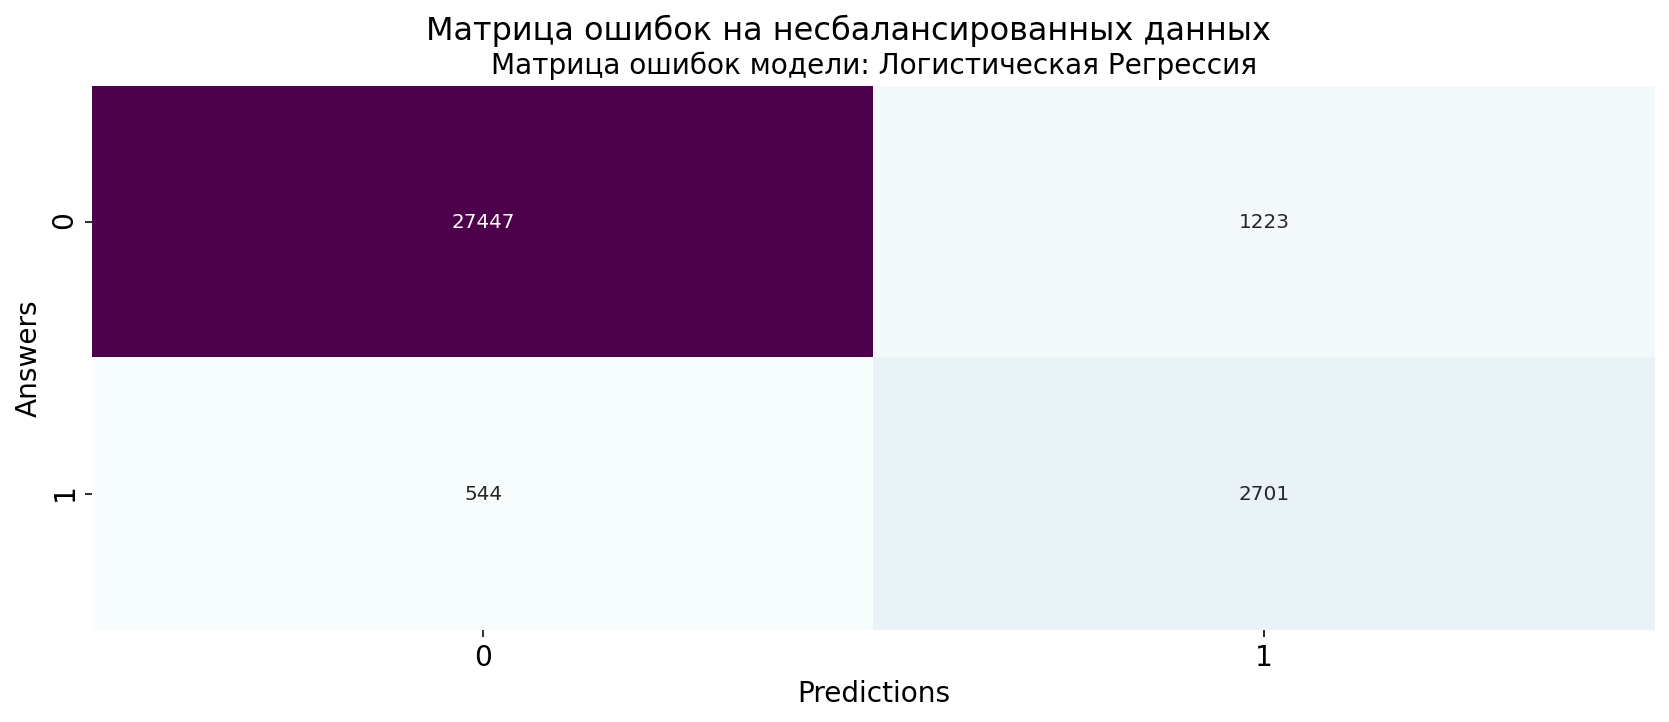

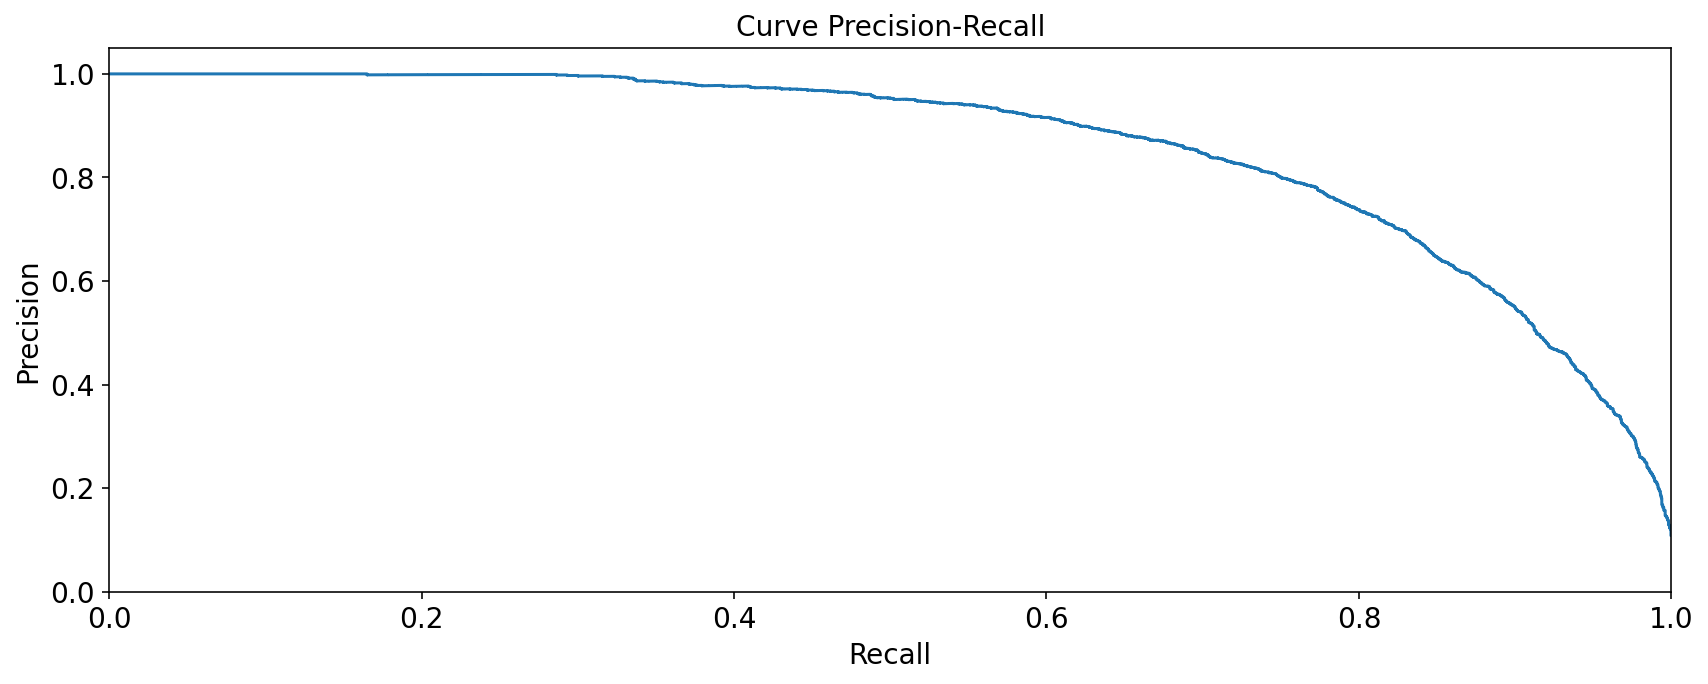

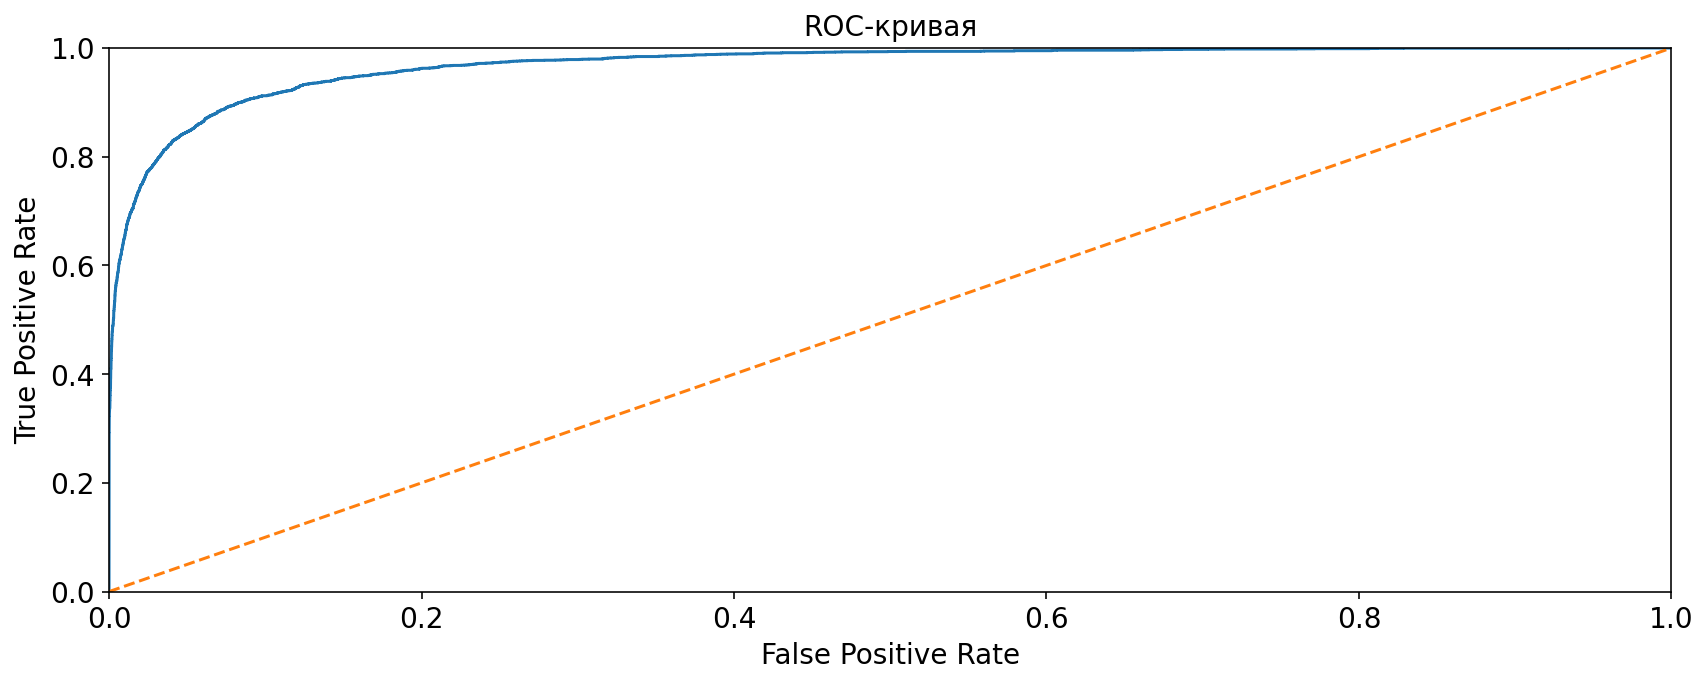


Recall - 0.8323574730354392
Precision - 0.6883282364933742
F1-Score - 0.7535221090807644
AUC-ROC_score - 0.9687743317910682

Модель успешно добавлена в таблицу!


In [43]:
evaluate_model("Логистическая Регрессия", gs_logistic.best_estimator_, gs_logistic.best_score_, features_test, target_test,gs_logistic.best_params_)

Модель показала хороший показатель на метрике F1-score - **0.75**. Перейдём к Дереву решений.

<a id="decisionTree"></a>
### Decision Tree с перебором параметров

In [44]:
%%time
# Параметры, которые мы перебираем
gs_params = {
    'max_depth': range(1, 11),
    'min_samples_leaf':range(1,11)
}
# Создаем GridSearch для модели
gs_tree = RandomizedSearchCV(DecisionTreeClassifier(random_state=random_state_value),gs_params,scoring='f1',cv=5, n_iter=20)
# Обучаем модель
gs_tree.fit(features_train,target_train)

CPU times: user 30min 38s, sys: 1.39 s, total: 30min 39s
Wall time: 30min 39s


Оценка модели: Дерево решений
с параметрами: {'min_samples_leaf': 3, 'max_depth': 10}
Точность модели на обучающей выборке: 0.6058815419992334
Точность модели на тестовой выборке: 0.9324768917436942



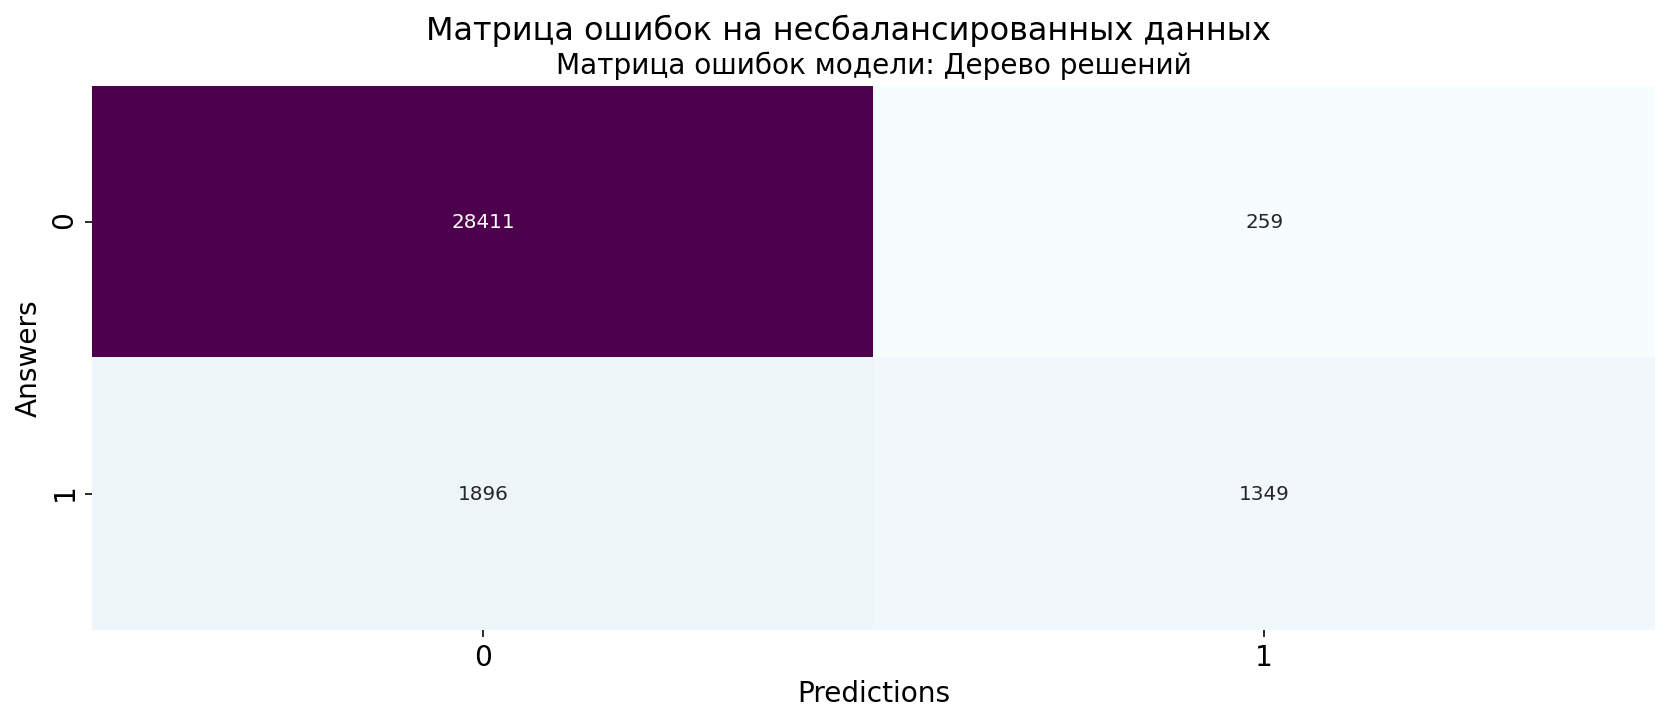

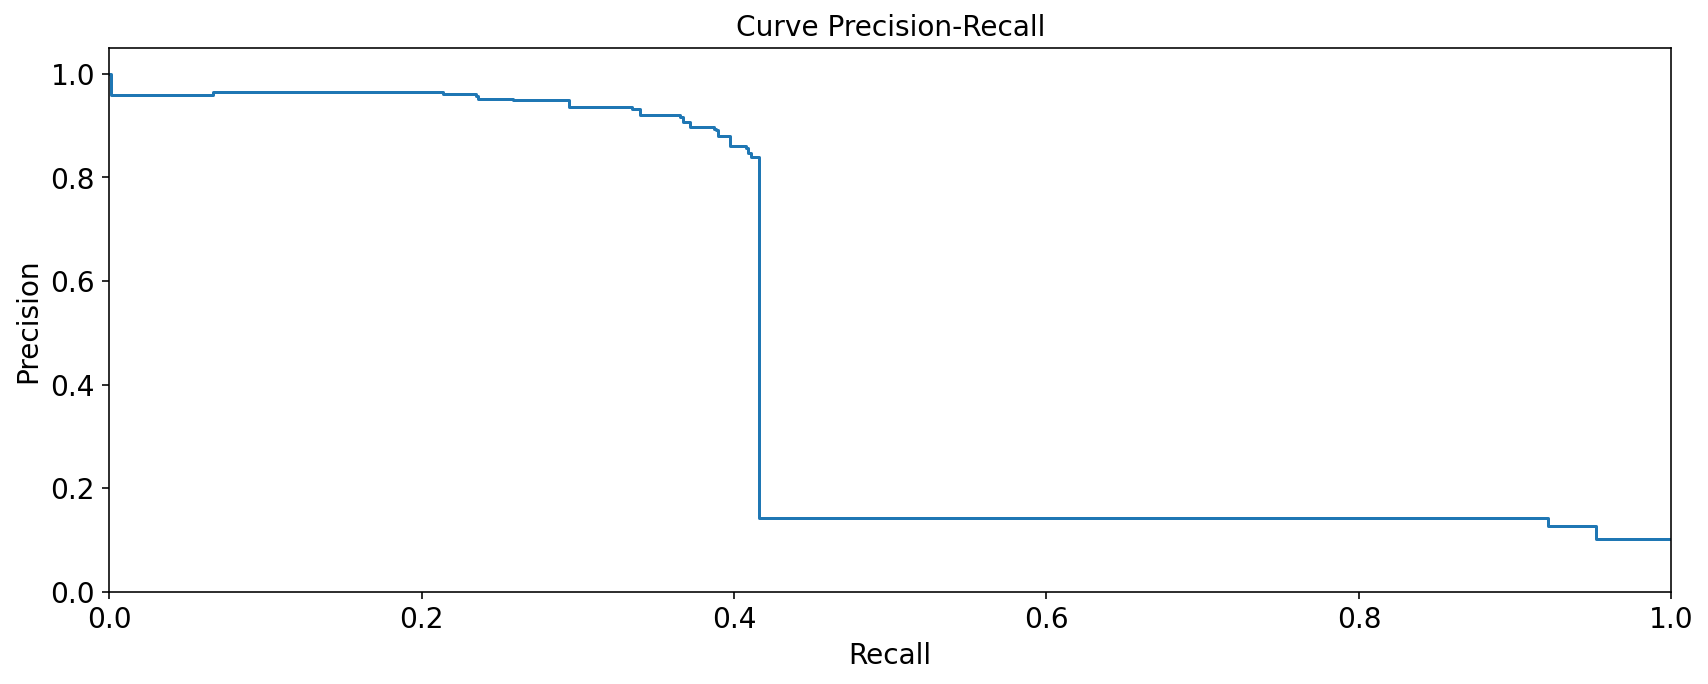

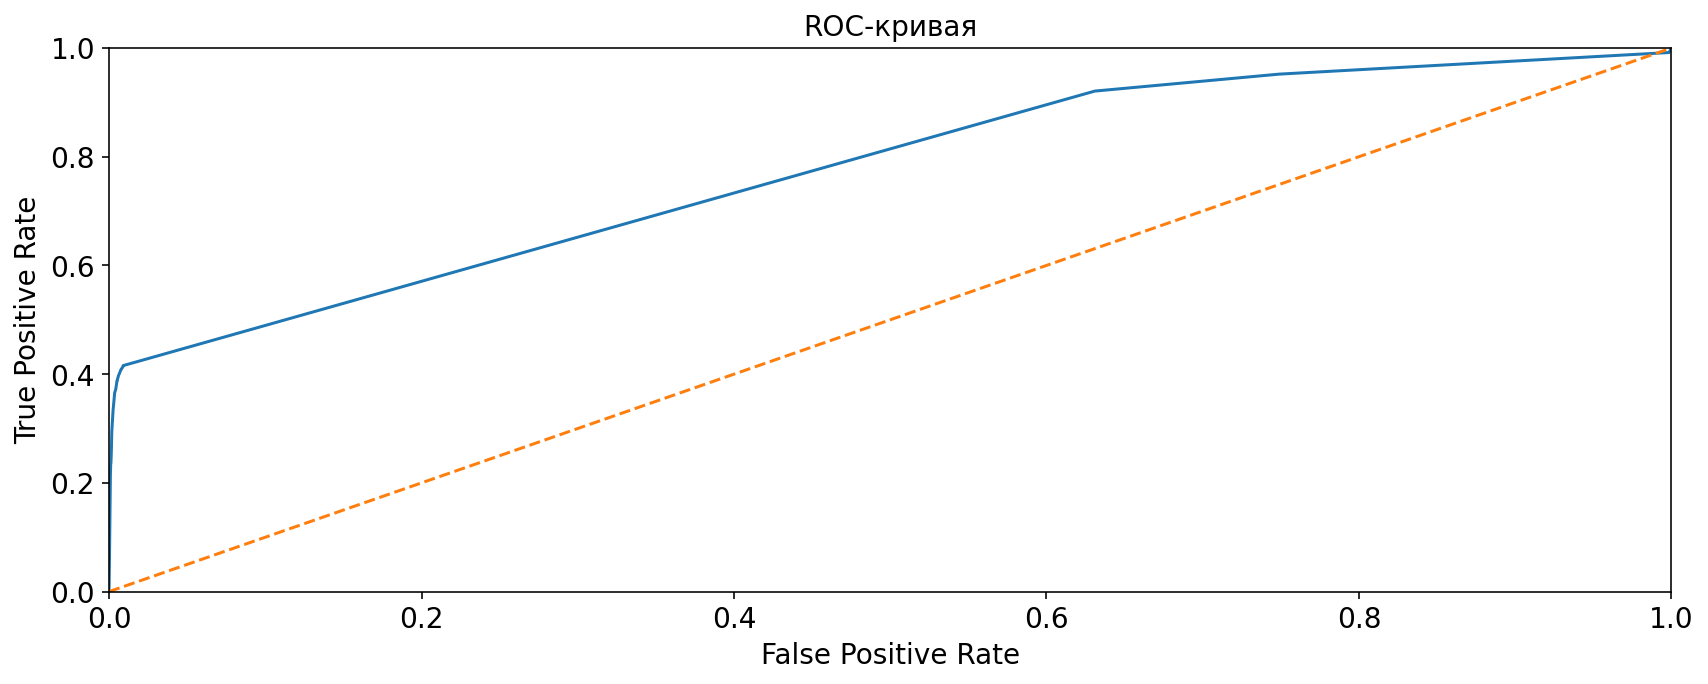


Recall - 0.41571648690292756
Precision - 0.8389303482587065
F1-Score - 0.5559447764269524
AUC-ROC_score - 0.7731533850741905

Модель успешно добавлена в таблицу!


In [45]:
evaluate_model("Дерево решений", gs_tree.best_estimator_, gs_tree.best_score_, features_test, target_test,gs_tree.best_params_)

Показатель метрики F1-score упал до - **0.55**. Посмотрим на Random Forest

<a id="randomForest"></a>
## Random Forest с перебором параметров 

In [46]:
%%time
# Параметры, которые мы перебираем
rs_params = {
    'max_depth': range(1, 26),
    'min_samples_leaf':range(1,11)
}
# Создаем GridSearch для модели
tree_balanced_rs = RandomizedSearchCV(RandomForestClassifier(random_state=random_state_value),rs_params,scoring='f1',cv=5, n_iter=20)
# Обучаем модель
tree_balanced_rs.fit(features_train, target_train)

CPU times: user 1h 32min 23s, sys: 13.9 s, total: 1h 32min 36s
Wall time: 1h 32min 36s


Оценка модели: Random Forest
с параметрами: {'min_samples_leaf': 3, 'max_depth': 25}
Точность модели на обучающей выборке: 0.845056972541722
Точность модели на тестовой выборке: 0.8678364405451982



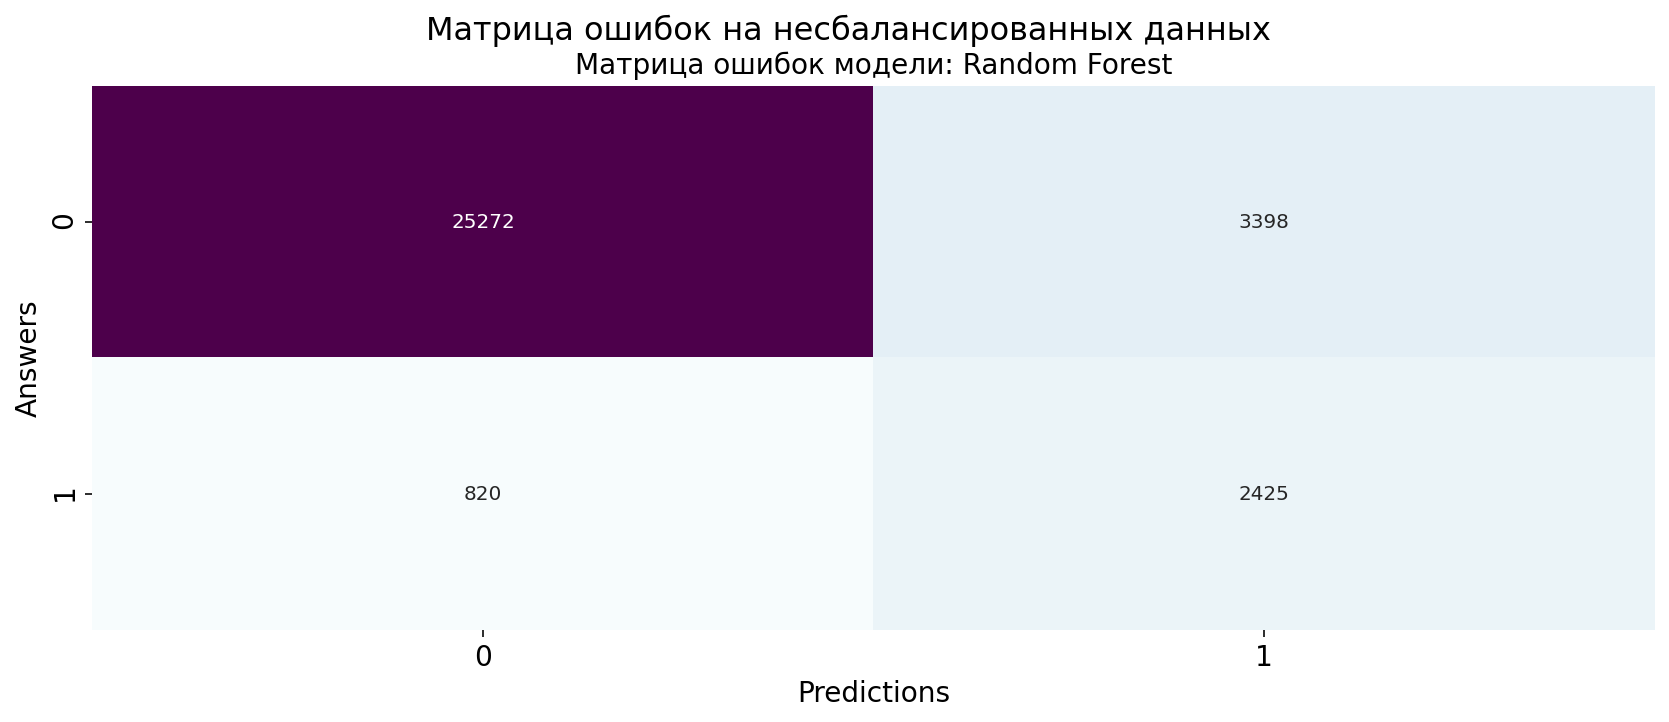

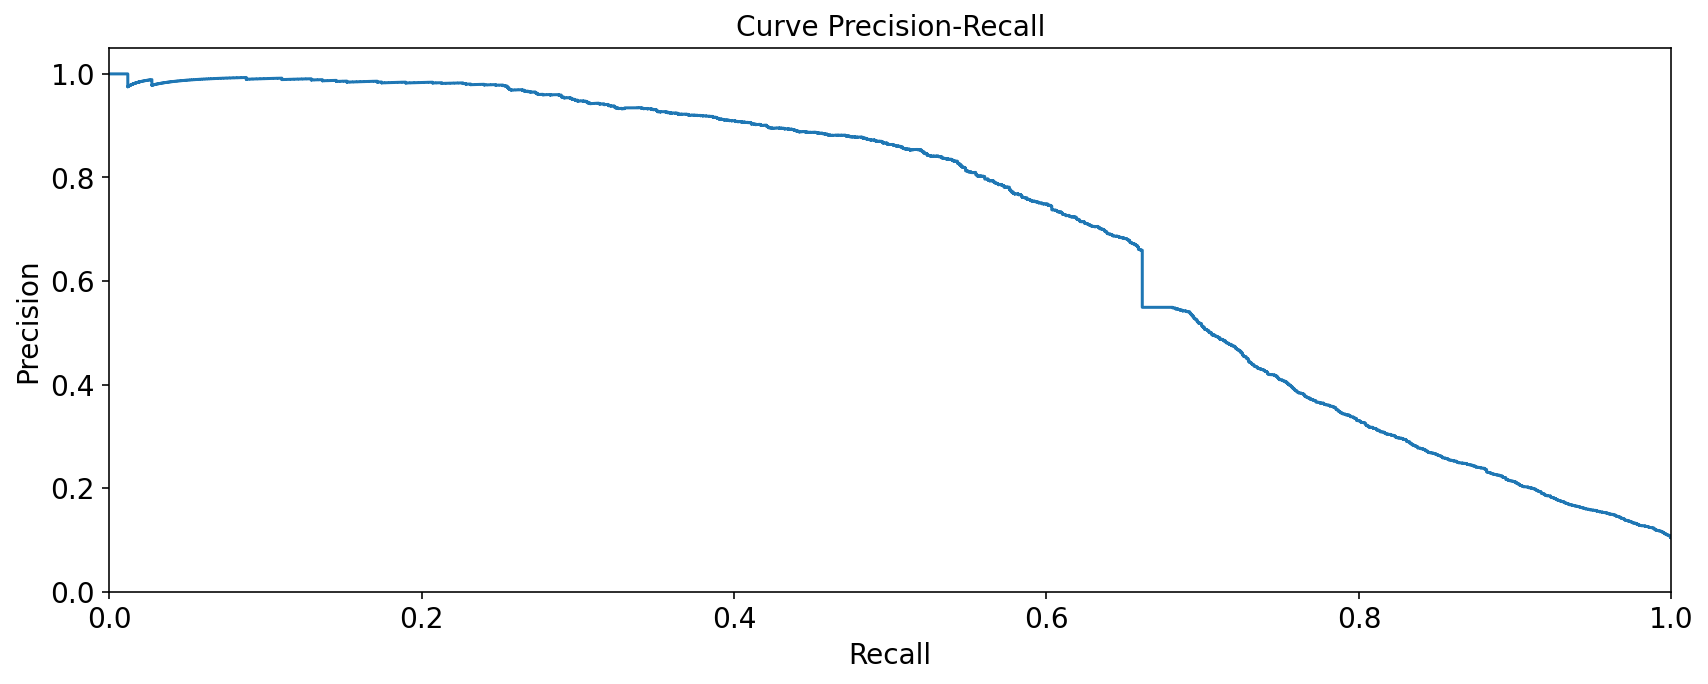

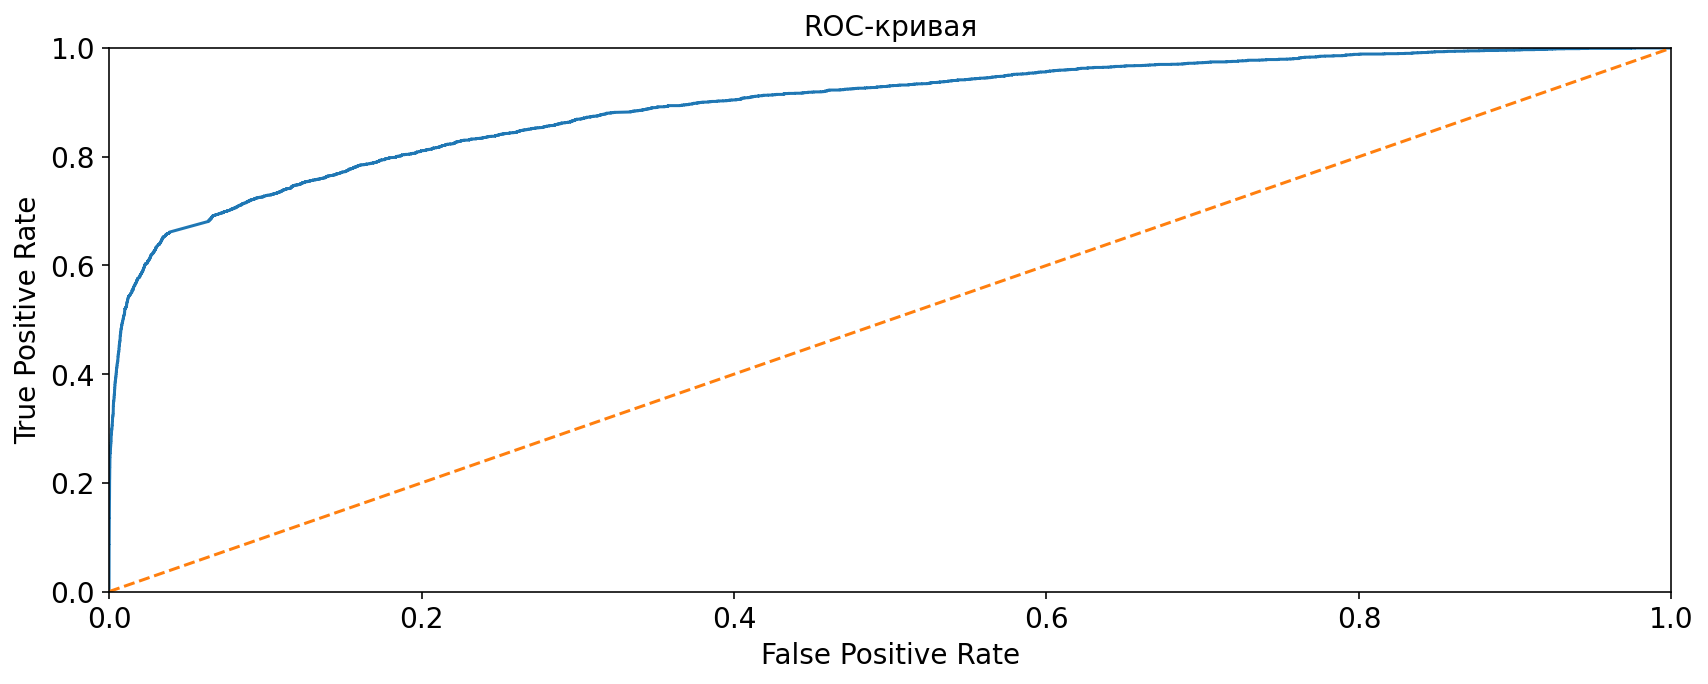


Recall - 0.7473035439137135
Precision - 0.4164520006869311
F1-Score - 0.5348478164975737
AUC-ROC_score - 0.8936828680651137

Модель успешно добавлена в таблицу!


In [47]:
evaluate_model("Random Forest", tree_balanced_rs.best_estimator_, tree_balanced_rs.best_score_, features_test, target_test,tree_balanced_rs.best_params_)

Пока что лучшая модель - Логистическая Регрессия. У рандомного леса, значение F1-score - **0.53**. Перейдём к бустингам.

<a id="XGBoost"></a>
## XGBoost

In [48]:
%%time
xgb_params = {
    "max_depth": range(3, 10,2),
    "min_child_weight": range(1,6,2)
}
xgb = xgb.XGBClassifier(nthread=-1) 
xgb_gs = RandomizedSearchCV(xgb, xgb_params, scoring='f1',n_jobs=-1, n_iter=20)
xgb_gs.fit(features_train,target_train)

CPU times: user 7min 4s, sys: 2.47 s, total: 7min 7s
Wall time: 1h 3min 30s


Оценка модели: XGBoost с перебором параметров
с параметрами: {'min_child_weight': 1, 'max_depth': 9}
Точность модели на обучающей выборке: 0.854655942827207
Точность модели на тестовой выборке: 0.943286855710481



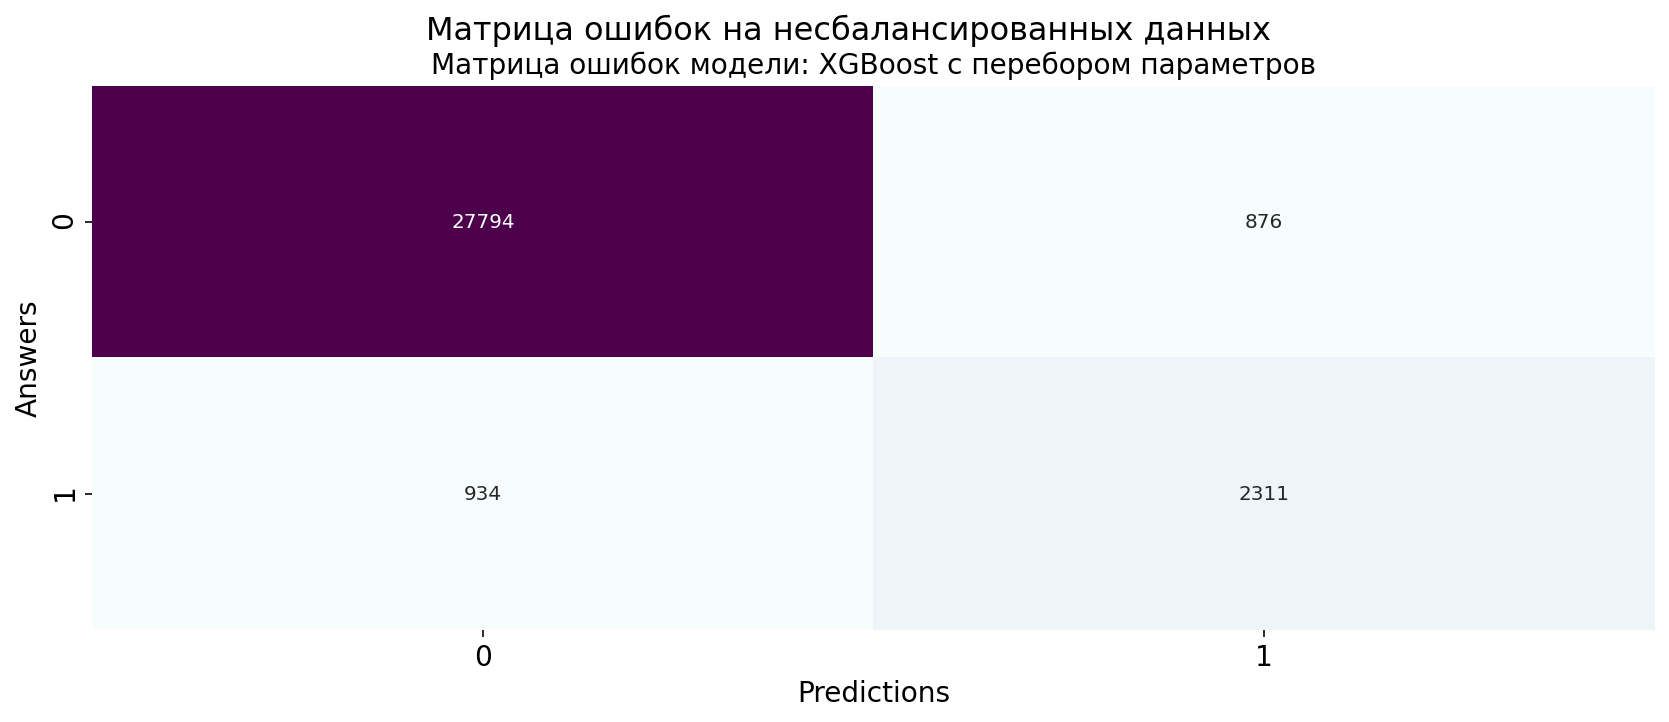

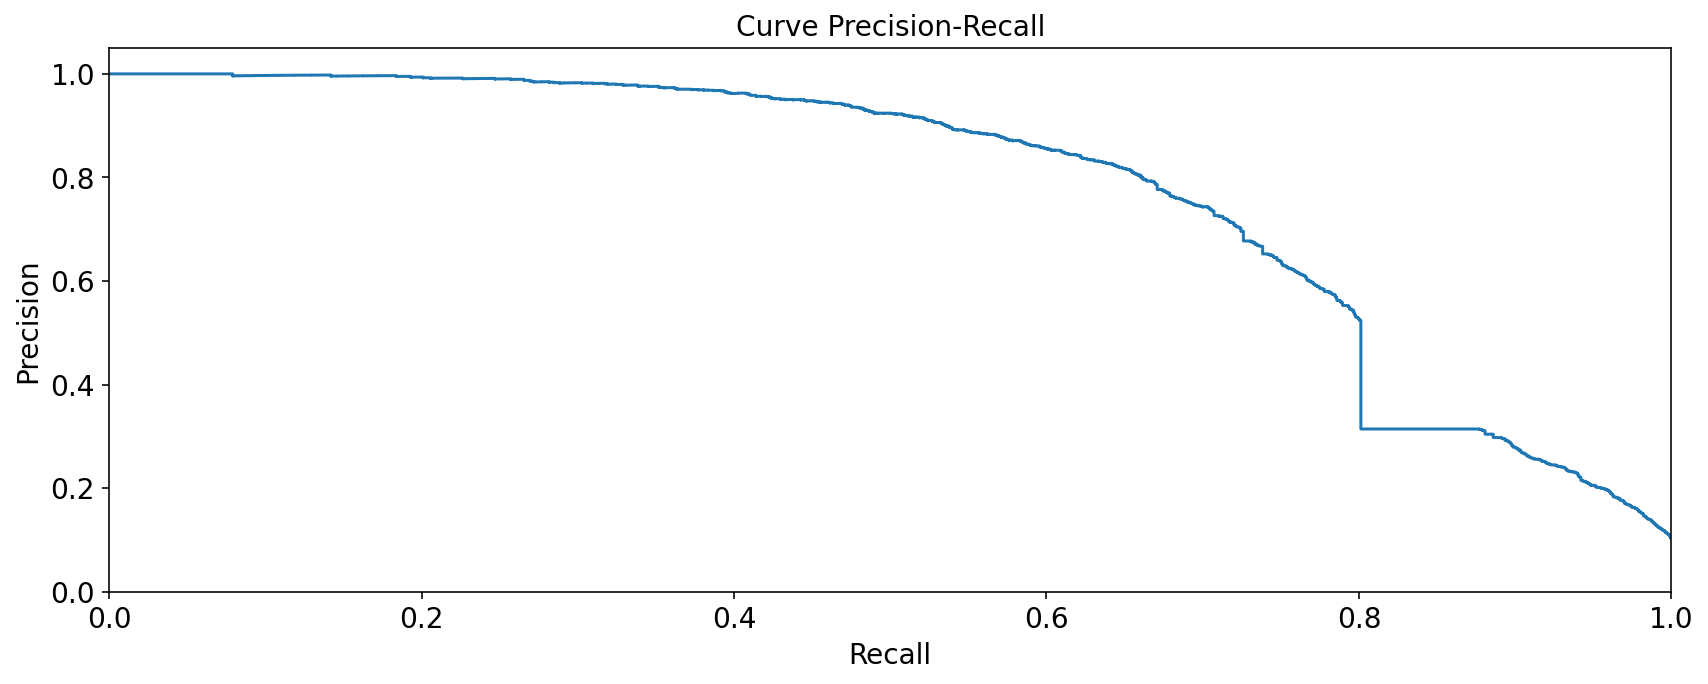

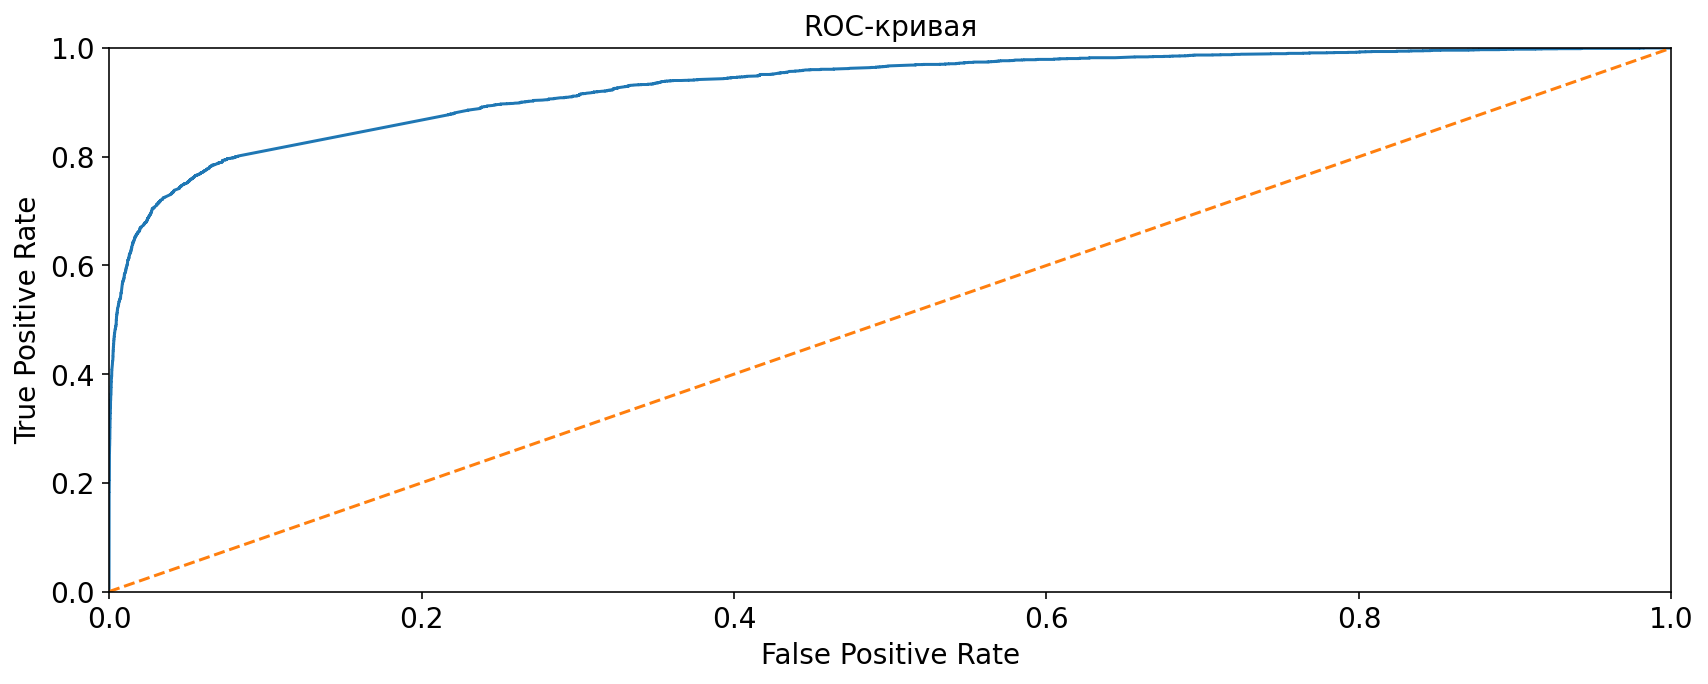


Recall - 0.7121725731895223
Precision - 0.7251333542516473
F1-Score - 0.7185945273631841
AUC-ROC_score - 0.928534312400339

Модель успешно добавлена в таблицу!


In [49]:
evaluate_model("XGBoost с перебором параметров", xgb_gs.best_estimator_, xgb_gs.best_score_, features_test, target_test,xgb_gs.best_params_)

XGBoost показал не плохой результат на F1-score - **0.71**. Посмотрим на LightGBM.

<a id="lightgmb"></a>
## LightGBM

In [50]:
%%time
lgb_params = {
    'objective': ['regression','binary'],
    'boosting_type' : ['dart','gbdt','goss'],
    'max_depth': [15,30],
    'num_leaves': [10,200,250]
}
lgb_reg = lgb.LGBMClassifier(random_state=random_state_value)
lgb_rs = RandomizedSearchCV(lgb_reg, lgb_params,scoring='f1', cv=5, n_iter=20)
lgb_rs.fit(features_train,target_train)

CPU times: user 6h 50min 59s, sys: 1min 26s, total: 6h 52min 26s
Wall time: 1h 48min 10s


Оценка модели: LightGBM с перебором параметров
с параметрами: {'objective': 'binary', 'num_leaves': 250, 'max_depth': 30, 'boosting_type': 'gbdt'}
Точность модели на обучающей выборке: 0.9402965611232922
Точность модели на тестовой выборке: 0.9478928403571988



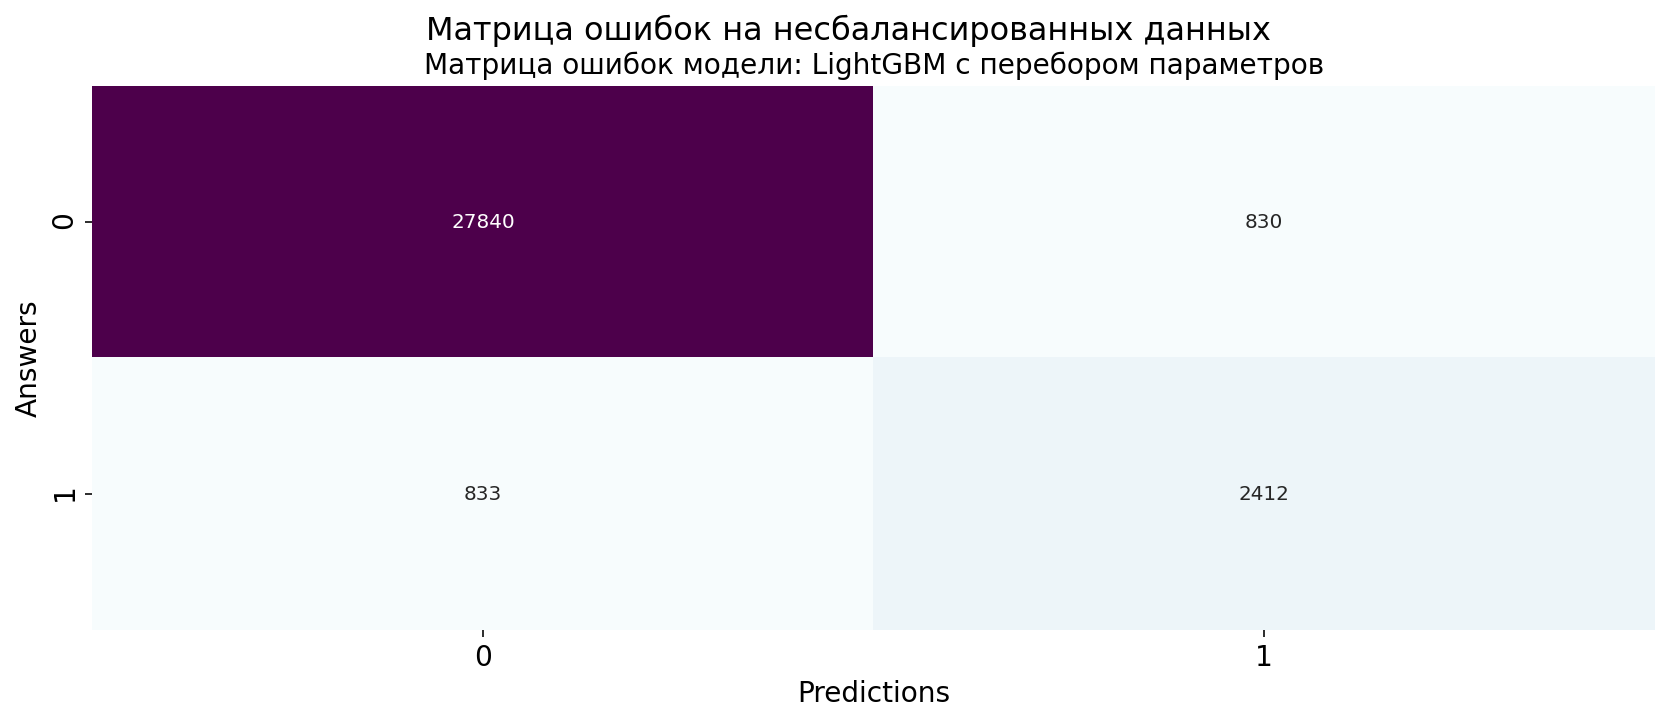

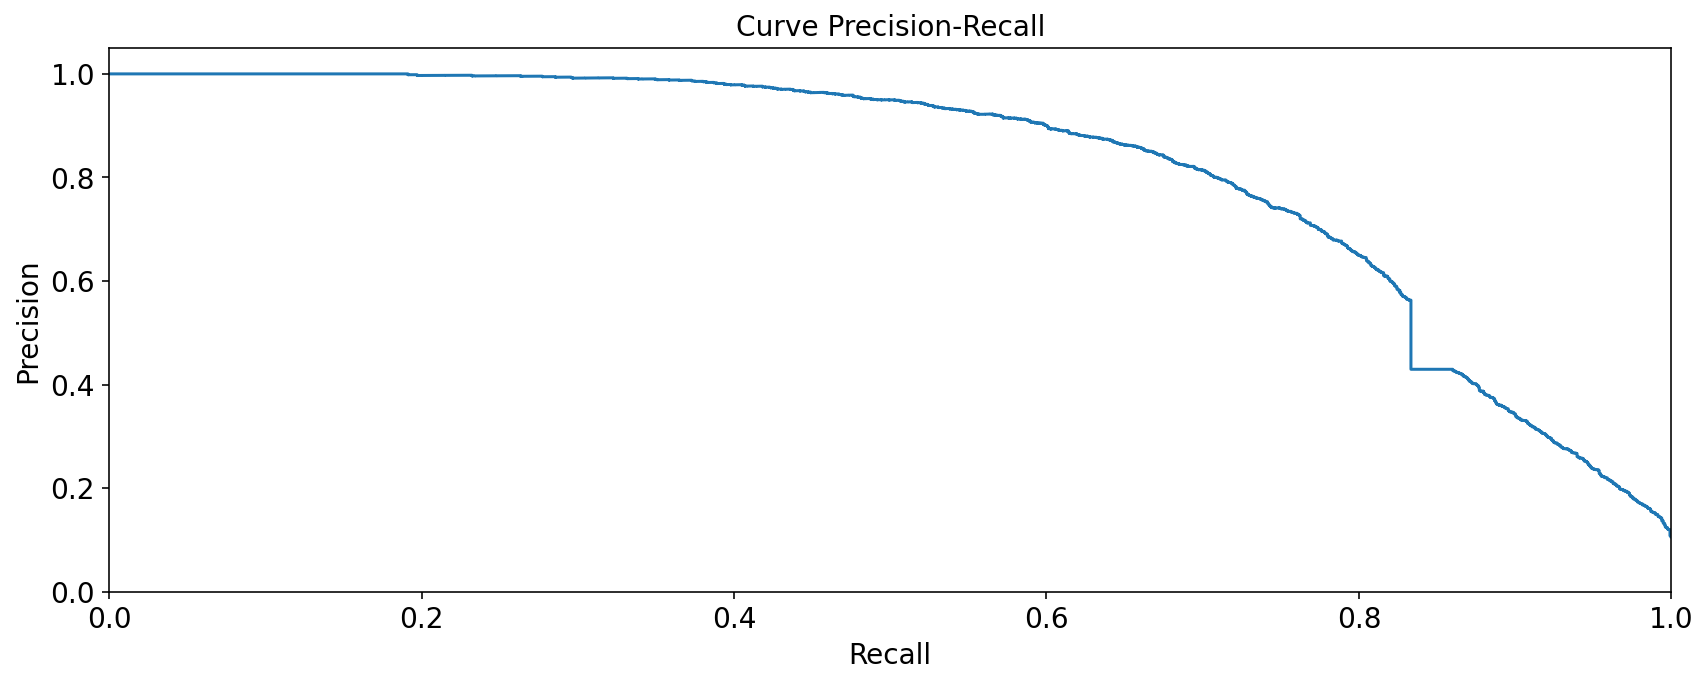

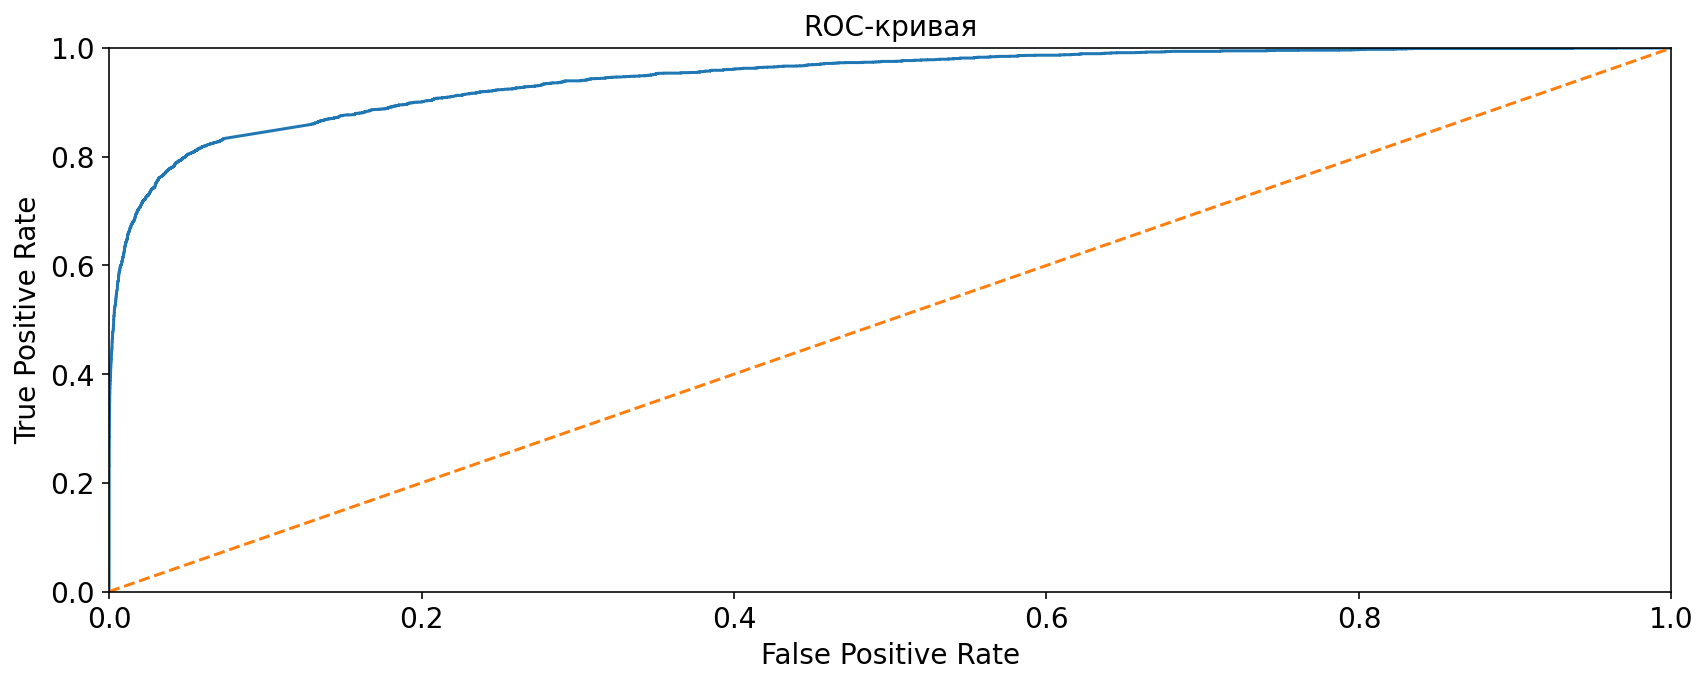


Recall - 0.7432973805855162
Precision - 0.7439851943244911
F1-Score - 0.7436411284106677
AUC-ROC_score - 0.9446816142244541

Модель успешно добавлена в таблицу!


In [58]:
evaluate_model("LightGBM с перебором параметров", lgb_rs.best_estimator_, lgb_rs.best_score_, features_test, target_test,lgb_rs.best_params_)

Модель показала хороший результат на метрике F1-score - **0.74**. Осталось проверить модели на вменяемость. Обучить dummy модель.

<a id="dummy"></a>
## DummyClassifier

In [52]:
%%time
# Создание dummy модели, указывая константу = 1
dummy_model = DummyClassifier(strategy='constant',constant=1, random_state=random_state_value)
# Обучение
dummy_model.fit(features_train,target_train)

CPU times: user 12.7 ms, sys: 2 µs, total: 12.7 ms
Wall time: 12.3 ms


Оценка модели: Dummy
Точность модели на обучающей выборке: 0.47520547694448007
Точность модели на тестовой выборке: 0.10167632774557418



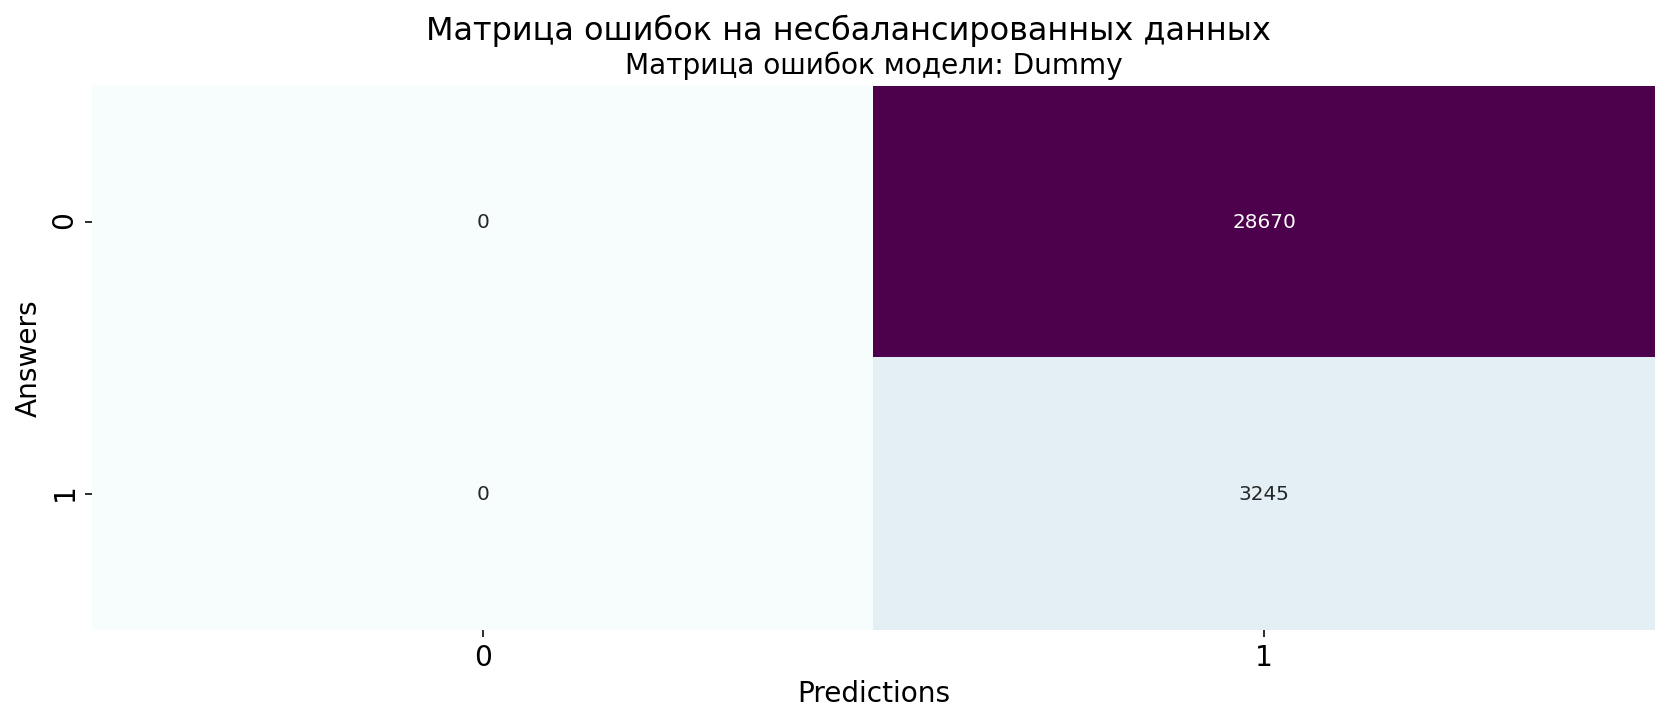

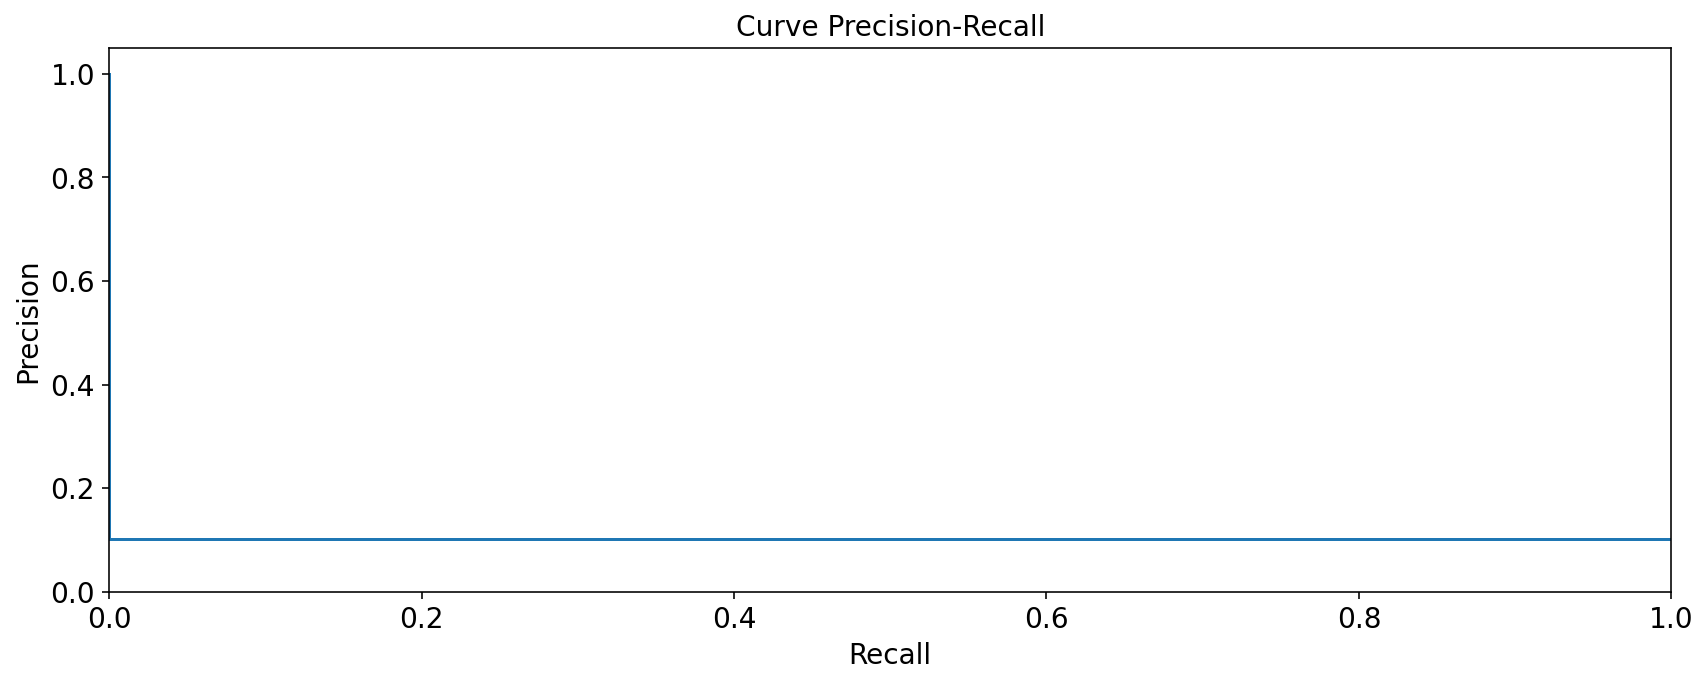

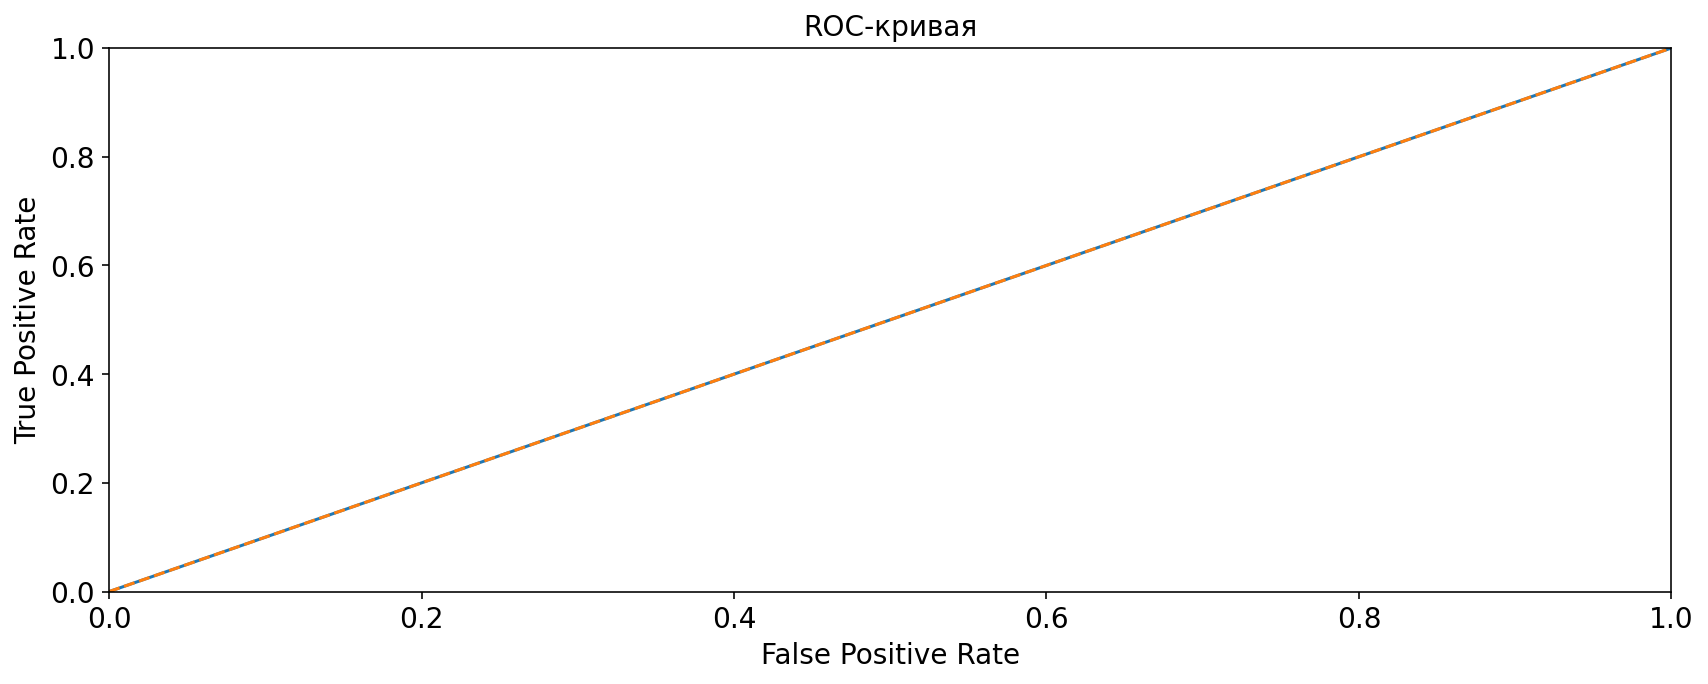


Recall - 1.0
Precision - 0.10167632774557418
F1-Score - 0.18458475540386804
AUC-ROC_score - 0.5

Модель успешно добавлена в таблицу!


In [56]:
evaluate_model("Dummy", dummy_model, dummy_model.score(features_train,target_train), features_test, target_test)

## Вывод
На этом этапе мы исследовали разные ML модели: Логистическая регрессия, Дерево Решения, Рандомный Лес, XGBoost, LightGBM. Написали функцию для оценки моделей.  Модели обучены. Перейдём к анализу результатов.

<a id="resultsRearchModel"></a>
# Этап 4 - Результаты исследования моделей машинного обучения

На этом этапе надо проанализировать качество моделей.

Мы провели исследование 5 моделей машинного обучения (*Logistic Regression*, *Decision Tree*, *Random Forest*, *XGBoost*, *LightGBM*).

Для бизнеса важна метрика F1. Должна быть не меньше 75.

Напишем дополнительную функцию для вывода графиков

In [54]:
def drawPlot(df,x_axis, y_axis, x_label, y_label,plot_title, order_by=None):
    """
    Функция отрисовки графика
    df - данные
    x_axis - ось x
    y_axis - ось y
    x_label - название оси x
    y_label - название оси y
    plot_title - заголовок
    order - столбец по которому будет определяться порядок
    """
    # Заголовок
    plt.title(plot_title)
    sns.barplot(x=x_axis,y=y_axis, data=df,order=df[order_by])
    # подписать оси 
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

Создадим таблицу из полученных данных.

In [60]:
ml_models = pd.DataFrame.from_dict(data=ml_models_stats, orient='index').reset_index(drop=True)
ml_models

,название,обучающая_точность,тестовая_точность,recall,precision,f1_score,auc_roc_score
0,Логистическая Регрессия,0.963,0.945,0.832,0.688,0.754,0.969
1,Дерево решений,0.606,0.932,0.416,0.839,0.556,0.773
2,Random Forest,0.845,0.868,0.747,0.416,0.535,0.894
3,XGBoost с перебором параметров,0.855,0.943,0.712,0.725,0.719,0.929
4,LightGBM с перебором параметров,0.940,0.948,0.743,0.744,0.744,0.945
5,Dummy,0.475,0.102,1.000,0.102,0.185,0.500


Модели которые прошли проверку на вменяемость.

In [61]:
approved_models = ml_models.query("f1_score > 0.185")
approved_models

,название,обучающая_точность,тестовая_точность,recall,precision,f1_score,auc_roc_score
0,Логистическая Регрессия,0.963,0.945,0.832,0.688,0.754,0.969
1,Дерево решений,0.606,0.932,0.416,0.839,0.556,0.773
2,Random Forest,0.845,0.868,0.747,0.416,0.535,0.894
3,XGBoost с перебором параметров,0.855,0.943,0.712,0.725,0.719,0.929
4,LightGBM с перебором параметров,0.940,0.948,0.743,0.744,0.744,0.945


Все модели прошли проверку на вменяемость. Найдём самую лучшую модель по метрике F1 на тестовой выборке

,название,f1_score
0,Логистическая Регрессия,0.754
1,LightGBM с перебором параметров,0.744
2,XGBoost с перебором параметров,0.719
3,Дерево решений,0.556
4,Random Forest,0.535


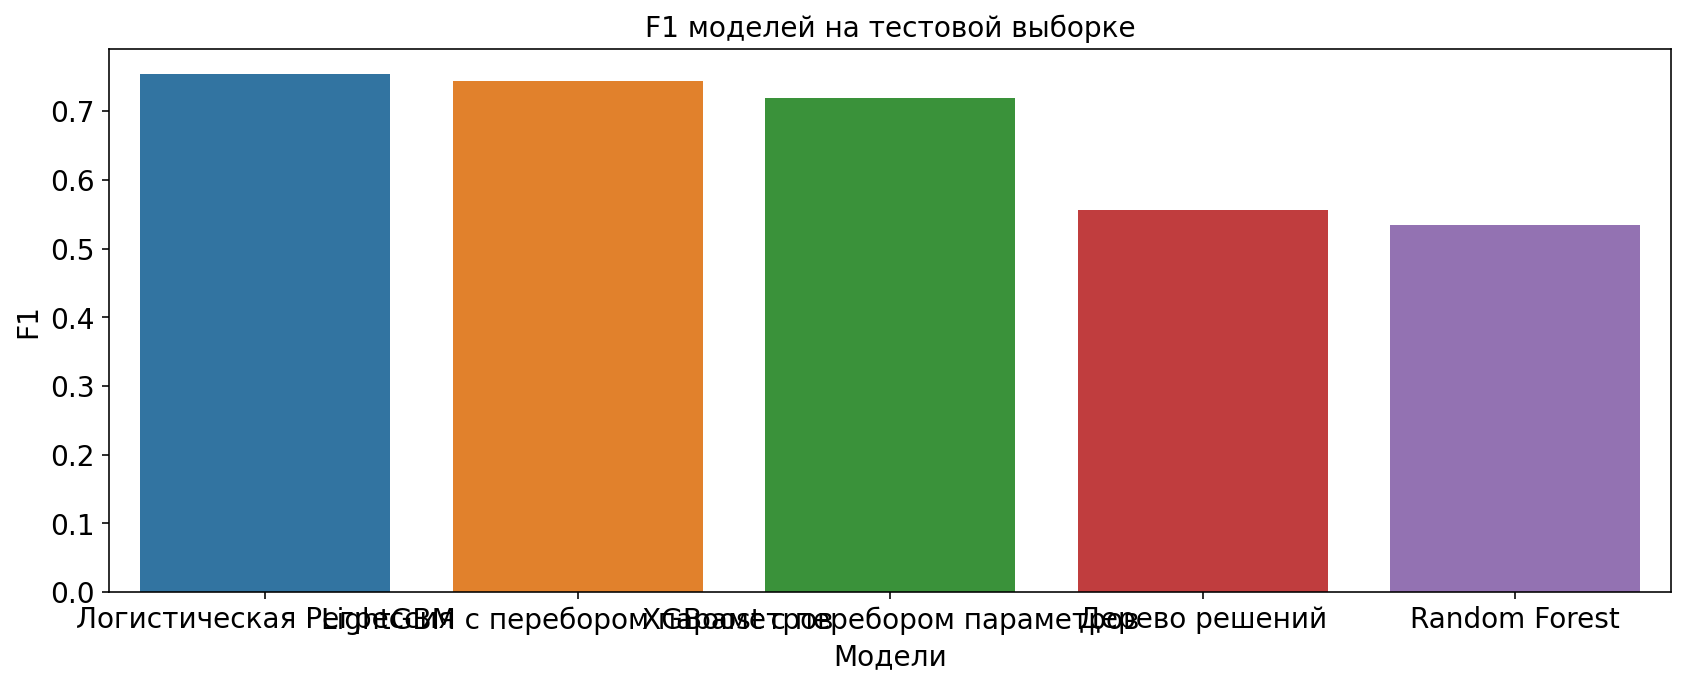

In [64]:
f1_test_sorted = approved_models.sort_values(by='f1_score',ascending=False).reset_index()
display(f1_test_sorted[['название','f1_score']])
# Рисуем график
drawPlot(f1_test_sorted, 'название','f1_score','Модели','F1','F1 моделей на тестовой выборке','название' )

Самой лучшей моделью оказалась **Логистическая Регрессия** с показателем - **0.754** на тестовой выборке.

Бизнесу важны модели, у которых F1 метрика не меньше 75. У нас одна модель которая соотвествует требованию бизнеса - **Логистическая Регрессия**.

<a id="results"></a>
# Этап 5 - Результаты работы

В ходе проекта мы успешно построили модель, которая классифицирует комментарии на позитивные и негативные. Тем самым, помогли бизнесу построить систему по поиску токсичных комментариев и отправке их на модернизацию. В проекте мы сделали:
1. Предобработка данных:
    - На этом этапе мы предобработали тексты: 
      - сделали лемматизацию
      - убрали спецсимволы, цифры
      -  Векторизовали текста. 
    - Разделили выборку на 75/25 - (обучающая и тестовая выборка).
2. Исследование моделей:
    - На этом этапе мы исследовали разные ML модели: 
      1. Логистическая регрессия
      2. Дерево Решения
      3. Рандомный Лес
      4. XGBoost
      5. LightGBM. 
    - Написали функцию для оценки моделей. Модели обучены.
3. Подвели результаты исследования:
    - Самой лучшей моделью оказалась **Логистическая Регрессия** с показателем - **0.754** на тестовой выборке.
    - Бизнесу важны модели, у которых F1 метрика не меньше 75. У нас одна модель которая соотвествует требованию бизнеса - **Логистическая Регрессия**.